In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from scipy.stats import linregress
from sklearn.model_selection import KFold
from pytorch_stats_model_multi_dim import * 
import glob, h5py
from tqdm import tqdm
from sklearn.metrics import r2_score 
import pickle
from scipy.optimize import least_squares
%matplotlib notebook
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.labelcolor': '0', 'text.color':'0', 'xtick.color':'0', 'ytick.color':'0'}),

SMALL_SIZE = 12
MEDIUM_SIZE = 21
BIGGER_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
from affine_model_constrast_specific_coefficient import * 

In [3]:
def soft_cluster(f):
    # cluster based on score of maximum absolute value
    cluster_ids = np.argmax(np.abs(f), axis=1)
    scores = f[range(f.shape[0]), cluster_ids]

    # resort within each cluster
    perm = []
    for cluster in np.unique(cluster_ids):
        idx = np.where(cluster_ids == cluster)[0]
        perm += list(idx[np.argsort(scores[idx])][::-1])
    return cluster_ids, perm

In [5]:
# load combined neuropixel data
with open('./dataset/dataset2/V1_V2_contrast_150r002p017_combine_2_trials.pkl', 'rb') as f:  
    n1, n2, spk_V1_sum, spk_V2_sum  = pickle.load(f)

spk_V1_tmp = spk_V1_sum[:n1, :, :]
spk_V2_tmp = spk_V2_sum[:n2, :, :]

V1_f = np.reshape(spk_V1_tmp, (n1, -1), order='F')
V2_f = np.reshape(spk_V2_tmp, (n2, -1), order='F')

V1_tuning = np.mean(spk_V1_sum[:n1, :, 16:],axis=1)
V2_tuning = np.mean(spk_V2_sum[:n2, :, 16:],axis=1)
    
pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

n1,n2

(106, 131)

In [6]:
#exclude silent neurons
if (V1_tuning==0).any():
    id_silent = np.unique(np.where(V1_tuning==0)[0])
    print(id_silent)
    V1_f = np.delete(V1_f, id_silent, axis=0)
    V1_tuning = np.delete(V1_tuning, id_silent, axis=0)
    n1 -= id_silent.shape[0]
    print(V1_f.shape)

if (V2_tuning==0).any():
    id_silent = np.unique(np.where(V2_tuning==0)[0])
    print(id_silent)
    V2_f = np.delete(V2_f, id_silent, axis=0)
    V2_tuning = np.delete(V2_tuning, id_silent, axis=0)
    n2 -= id_silent.shape[0]
    print(V2_f.shape)

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

In [7]:
def calculate_OTI_direct(spk_V1_sum):
    
    tuning = np.mean(spk_V1_sum[:,:, 16:],1)
    max_tuning = np.max(tuning,1)
    min_tuning = np.min(tuning,1)

    OTI = (max_tuning-min_tuning)/(max_tuning+min_tuning)
    return OTI

In [8]:
OTI_V1_direct = calculate_OTI_direct(spk_V1_sum)
OTI_V2_direct = calculate_OTI_direct(spk_V2_sum)

In [9]:
thr = 0.35
print(len(np.where(OTI_V1_direct>thr)[0]))
print(len(np.where(OTI_V2_direct>thr)[0]))


46
74


In [10]:
n1 = np.sum(OTI_V1_direct>thr)
n2 = np.sum(OTI_V2_direct>thr)

V1_f_new = V1_f[OTI_V1_direct>thr, :]
V2_f_new = V2_f[OTI_V2_direct>thr, :]

V1_f= V1_f_new
V2_f= V2_f_new

V1_tuning = np.mean(spk_V1_tmp[OTI_V1_direct>thr,:,:],axis=1)
V2_tuning = np.mean(spk_V2_tmp[OTI_V2_direct>thr,:,:],axis=1)

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

In [11]:
n_stim = 24
n_trial =100
V1_f_ = V1_f.reshape((n1, n_trial, n_stim), order='F')
V2_f_ = V2_f.reshape((n2, n_trial, n_stim), order='F')

n_trial_train = 80
n_trial_test = 20

In [12]:
n_ori = 8
n_contrast = 3

## Fit statistical models

In [ ]:
aff_model_V1_all = []  # affine model fit to V1 data
add_varp_model_V1_all = [] # additive model fit to V1 data
gen_model_V1_all = [] # generalized model fit to V1 data
add_model_V1_all = []  # This is NOT the additive model used in Xia et al 2023, this additive model assumes stimulus-independent private variability
aff_model_contrast_V1_all = [] # generalized affine model fit to V1 data

# same set of statistical models fit to V2 data
aff_model_V2_all = []
add_varp_model_V2_all = []
gen_model_V2_all = []
add_model_V2_all = []
aff_model_contrast_V2_all =[]

# index of trials in 5-fold cross-validation
train_ind_all = []
test_ind_all = []

kf = KFold(n_splits=5,shuffle=True)
split=0

for train_ind, test_ind in kf.split(np.arange(n_trial)):        
    split += 1
    
    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')
    
    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')
    
    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')
    
    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')

    train_ind_all.append(train_ind)
    test_ind_all.append(test_ind)
    
    for n_compo in tqdm(range(1,6)):

        gen_model_V1 = generalized_model(x1, n1, n_stim, n_trial_train, x_test1, n_trial_test, n_compo)
        add_model_V1 = additive_model(x1, n1, n_stim, n_trial_train, x_test1, n_trial_test, n_compo)

        gen_model_V1_all.append(gen_model_V1)
        add_model_V1_all.append(add_model_V1)
        
        #########
        gen_model_V2 = generalized_model(x2, n2, n_stim, n_trial_train, x_test2, n_trial_test, n_compo)
        add_model_V2 = additive_model(x2, n2, n_stim, n_trial_train, x_test2, n_trial_test, n_compo)

        gen_model_V2_all.append(gen_model_V2)
        add_model_V2_all.append(add_model_V2)
        
        #########
        h_p_init = add_model_V1.h_p.copy()
        psi_p_init = gen_model_V1.psi_p.copy()

        add_varp_model_V1 = additive_varp_model(x1, n1, n_stim, n_trial_train, n_compo, h_p_init, psi_p_init)
        d_add_varp_V1, h_add_varp_V1, psi_add_varp_V1 = add_varp_model_V1.train(1e-2, x1, n_trial_train)

        add_varp_model_V1_all.append(add_varp_model_V1) 
        
        ###################################
        h_p_init = add_model_V2.h_p.copy()
        psi_p_init = gen_model_V2.psi_p.copy()

        add_varp_model_V2 = additive_varp_model(x2, n2, n_stim, n_trial_train, n_compo, h_p_init, psi_p_init)
        d_add_varp_V2, h_add_varp_V2, psi_add_varp_V2 = add_varp_model_V2.train(1e-2, x2, n_trial_train)

        add_varp_model_V2_all.append(add_varp_model_V2) 
        
        
        ##############
        alpha_p_init = np.zeros((n1, n_compo))
        beta_p_init = add_model_V1.h_p.copy()
        psi_p_init = gen_model_V1.psi_p.copy()

        aff_model_V1 = affine_model(x1, n1, n_stim, n_trial_train, n_compo, alpha_p_init, beta_p_init, psi_p_init)
        d_aff_V1, alpha_aff_V1, beta_aff_V1, psi_aff_V1 = aff_model_V1.train(1e-2, x1, n_trial_train)

        aff_model_V1_all.append(aff_model_V1)
        
        
        ##############
        alpha_p_init = np.zeros((n2, n_compo))
        beta_p_init = add_model_V2.h_p.copy()
        psi_p_init = gen_model_V2.psi_p.copy()

        aff_model_V2 = affine_model(x2, n2, n_stim, n_trial_train, n_compo, alpha_p_init, beta_p_init, psi_p_init)
        d_aff_V2, alpha_aff_V2, beta_aff_V2, psi_aff_V2 = aff_model_V2.train(1e-2, x2, n_trial_train)

        aff_model_V2_all.append(aff_model_V2)
        
        
        ###########
        
        beta_p_init = add_model_V1.h_p.copy()
        psi_p_init = gen_model_V1.psi_p.copy()

        aff_model_contrast_V1 = affine_model_contrast_specific_coeff(x1, n1, n_ori, n_contrast, n_trial_train, n_compo, beta_p_init, psi_p_init)
        d_aff_V1, alpha_aff_V1, beta_aff_V1, psi_aff_V1 = aff_model_contrast_V1.train(1e-2, x1, n_trial_train)

        aff_model_contrast_V1_all.append(aff_model_contrast_V1)
        
        ##########
        beta_p_init = add_model_V2.h_p.copy()
        psi_p_init = gen_model_V2.psi_p.copy()

        aff_model_contrast_V2 = affine_model_contrast_specific_coeff(x2, n2, n_ori, n_contrast, n_trial_train, n_compo, beta_p_init, psi_p_init)
        d_aff_V2, alpha_aff_V2, beta_aff_V2, psi_aff_V2 = aff_model_contrast_V2.train(1e-2, x2, n_trial_train)

        aff_model_contrast_V2_all.append(aff_model_contrast_V2)
        

## Load trained models

In [13]:
with open('./stats_model_fitting_res/stats_model_res/dataset2/150_pytorch_neuropixel_all_contrasts_5_fold_cv_exclude_OTI_less_035_multidim_w_aff_con.pkl', 'rb') as fp:
    [train_ind_all, test_ind_all,
     aff_model_V1_all, aff_model_V2_all,
     aff_model_contrast_V1_all, aff_model_contrast_V2_all,
     add_varp_model_V1_all, add_varp_model_V2_all,
     gen_model_V1_all, gen_model_V2_all,
     add_model_V1_all, add_model_V2_all] = pickle.load(fp)

In [13]:
# stats_model_list = [add_varp_model_V1_all, aff_model_V1_all, aff_model_contrast_V1_all,
#                     add_varp_model_V2_all, aff_model_V2_all, aff_model_contrast_V2_all]
# for stats_model in stats_model_list:
#     for model in stats_model:
#         model.SMALL = 1e-5

## Plot fitting performances (log-likelihood) of statistical models

In [13]:
def plot_LL(x, x_test, add_model, add_varp_model, aff_model, aff_model_contrast, gen_model):
    ll_add = -add_model.NLL
    ll_add_test = -add_model.NLL_test

    ll_add_varp = -add_varp_model.loss_nll(x, n_trial_train)
    ll_add_varp_test = -add_varp_model.loss_nll(x_test, n_trial_test)

    ll_aff = -aff_model.loss_nll(x, n_trial_train)
    ll_aff_test = -aff_model.loss_nll(x_test, n_trial_test)
    
    ll_aff_contrast = -aff_model_contrast.loss_nll(x, n_trial_train)
    ll_aff_contrast_test = -aff_model_contrast.loss_nll(x_test, n_trial_test)

    ll_gen = -gen_model.NLL
    ll_gen_test = -gen_model.NLL_test

    ll_train = [ll_add, ll_add_varp.detach().numpy(),  ll_aff.detach().numpy(), ll_aff_contrast.detach().numpy(), ll_gen]
    ll_test = [ll_add_test, ll_add_varp_test.detach().numpy(), ll_aff_test.detach().numpy(), ll_aff_contrast_test.detach().numpy(), ll_gen_test]

    return ll_train, ll_test

In [14]:
n_compo_len = 5
n_fold = 5

ll_train1_all = np.zeros((5, n_compo_len, n_fold))
ll_test1_all = np.zeros((5, n_compo_len, n_fold))

ll_train2_all = np.zeros((5, n_compo_len, n_fold))
ll_test2_all = np.zeros((5, n_compo_len, n_fold))

#colors = ['b','g','r','c','m','y','k']
colors = plt.cm.inferno(np.linspace(0, 0.9,n_compo_len))


# plot for different component
for i in range(n_compo_len):
    for j in range(n_fold):
        
        train_ind = train_ind_all[j]
        test_ind = test_ind_all[j]

        V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
        V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

        V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
        V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

        x1 = V1_f_train.reshape(n1, -1, order='F')
        x_test1 = V1_f_test.reshape(n1, -1, order='F')

        x2 = V2_f_train.reshape(n2, -1, order='F')
        x_test2 = V2_f_test.reshape(n2, -1, order='F')


        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        aff_model_contrast_V1 = aff_model_contrast_V1_all[i+j*n_compo_len]
        
        
        
        
        ll_train1, ll_test1 = plot_LL(x1, x_test1, add_model_V1, add_varp_model_V1, aff_model_V1, aff_model_contrast_V1, gen_model_V1)

        
        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]

        aff_model_contrast_V2 = aff_model_contrast_V2_all[i+j*n_compo_len]
        
        ll_train2, ll_test2 = plot_LL(x2, x_test2, add_model_V2, add_varp_model_V2, aff_model_V2, aff_model_contrast_V2, gen_model_V2)

        ll_train1_all[:,i,j] = ll_train1
        ll_test1_all[:,i,j] = ll_test1

        ll_train2_all[:,i,j] = ll_train2
        ll_test2_all[:,i,j] = ll_test2


<IPython.core.display.Javascript object>


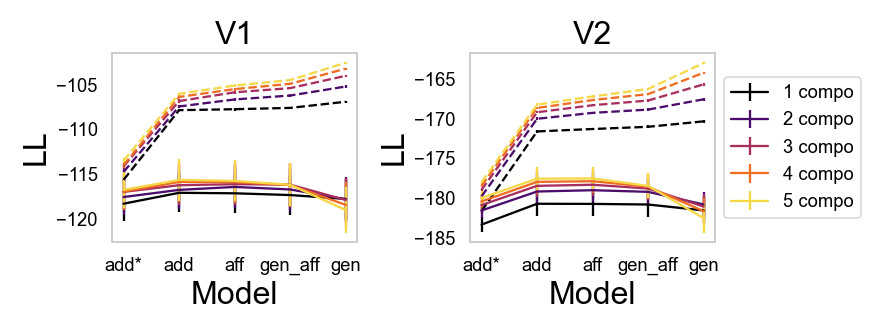

In [15]:
fig,ax = plt.subplots(1,2, figsize=(8,3))
for i in range(n_compo_len):
    ax[0].errorbar(np.arange(5), np.mean(ll_train1_all[:,i,:],1),np.std(ll_train1_all[:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[0].errorbar(np.arange(5), np.mean(ll_test1_all[:,i,:],1),np.std(ll_test1_all[:,i,:],1)/np.sqrt(n_fold), color=colors[i])
    
    ax[1].errorbar(np.arange(5), np.mean(ll_train2_all[:,i,:],1),np.std(ll_train2_all[:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[1].errorbar(np.arange(5), np.mean(ll_test2_all[:,i,:],1),np.std(ll_test2_all[:,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax[0].set_title('V1')
ax[1].set_title('V2')

plt.sca(ax[0])
plt.xticks([0,1,2,3,4], ['add*', 'add', 'aff', 'gen_aff', 'gen'])
plt.ylabel('LL')
plt.xlabel('Model')


plt.sca(ax[1])
plt.xticks([0,1,2,3,4], ['add*', 'add', 'aff', 'gen_aff', 'gen'])
plt.ylabel('LL')
plt.xlabel('Model')
plt.legend()


# Shrink current axis by 20%
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

<IPython.core.display.Javascript object>


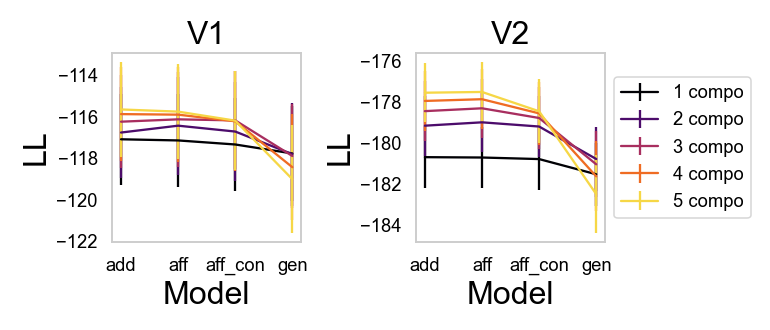

In [16]:
fig,ax = plt.subplots(1,2, figsize=(7,3))
for i in range(n_compo_len):
    #ax[0].errorbar(np.arange(4), np.mean(ll_train1_all[1:,i,:],1),np.std(ll_train1_all[1:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[0].errorbar(np.arange(4), np.mean(ll_test1_all[1:,i,:],1),np.std(ll_test1_all[1:,i,:],1)/np.sqrt(n_fold), color=colors[i])
    
    #ax[1].errorbar(np.arange(4), np.mean(ll_train2_all[1:,i,:],1),np.std(ll_train2_all[1:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[1].errorbar(np.arange(4), np.mean(ll_test2_all[1:,i,:],1),np.std(ll_test2_all[1:,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax[0].set_title('V1')
ax[1].set_title('V2')

plt.sca(ax[0])
plt.xticks([0,1,2,3], [ 'add', 'aff', 'aff_con', 'gen'])
plt.ylabel('LL', fontsize=21)
plt.xlabel('Model', fontsize=21)


plt.sca(ax[1])
plt.xticks([0,1,2,3], [ 'add', 'aff', 'aff_con', 'gen'])
plt.ylabel('LL', fontsize=21)
plt.xlabel('Model', fontsize=21)
plt.legend()


# Shrink current axis by 20%
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.savefig('2023_fig/contrast_neuropixel/LL_neuropixel_150.pdf',transparent=True)

<IPython.core.display.Javascript object>


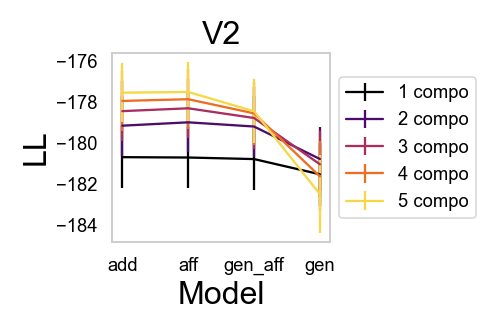

In [20]:
fig,ax = plt.subplots(1,1, figsize=(4.5,3))
for i in range(n_compo_len):
    ax.errorbar(np.arange(4), np.mean(ll_test2_all[1:,i,:],1),np.std(ll_test2_all[1:,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    
ax.set_title('V2')
plt.xticks([0,1,2,3], [ 'add', 'aff', 'gen_aff', 'gen'])
plt.ylabel('LL', fontsize=21)
plt.xlabel('Model', fontsize=21)
plt.legend()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.savefig('2023_fig/contrast_neuropixel/LL_neuropixel_150_only_V2.pdf',transparent=True)

## Plot fitting performance ($R^2$ of noise covariance) of statistical models

In [21]:
def calculate_nc(V1_f,n1, n_trial, n_stim=24):
    #calculate noise covariance 
    V1_spks_res = np.zeros((n_trial*n_stim, n1)) 
    for stim_i in range(n_stim):
        trial_avg = np.mean(V1_f[:, n_trial*stim_i: n_trial*(stim_i+1)],1)
        V1_spks_res[n_trial*stim_i: n_trial*(stim_i+1),:] = (V1_f[:,n_trial*stim_i: n_trial*(stim_i+1)] - trial_avg[:,np.newaxis]).T

    ncov_V1 = np.zeros((n1, n1, n_stim)) 
    
    ## plot nc with axis centered around neurons' whose pref ori match with the input
    for stim_i0 in range(n_stim):
        ncov_V1[:,:, stim_i0] = np.cov(V1_spks_res[n_trial*stim_i0: n_trial*(stim_i0 + 1), :].T)

    return ncov_V1

def calculate_r2_nc(ncov_V1, ncov_V1_add, n1, n_stim=24):
    #ncov from data
    x1 = np.zeros((int(n1*(n1-1)/2), n_stim))
    
    #ncov from model
    x2 = np.zeros((int(n1*(n1-1)/2), n_stim))
    
    for stim_i in range(n_stim):
        tmp = ncov_V1[:,:, stim_i]
        x1[:, stim_i] = tmp[np.triu_indices(n1, 1)]
        
        tmp = ncov_V1_add[:,:, stim_i]
        x2[:, stim_i] = tmp[np.triu_indices(n1, 1)]
        
    r2 = r2_score(x1, x2)
    return r2

In [22]:
model_label=['add*', 'add', 'aff', 'gen_aff', 'gen']


In [23]:
def calculate_ncov_from_phi(phi):
    #phi is n x n_compo x n_stim 
    ncov = np.einsum('ijk, ljk->ilk', phi, phi)
    return ncov

def calculate_phi_from_model(add_model, add_varp_model, aff_model, aff_contrast_model, gen_model, n_stim=24):
    phi_add = np.tile(add_model.h_p[:,:, None], (1,1,n_stim))
    
    phi_add_varp = np.tile(add_varp_model.h_p[:,:,None].detach().numpy(), (1,1,n_stim))
    
    phi_aff_tmp = aff_model.alpha_p[:,:,None]*aff_model.d_p[:,None,:]+aff_model.beta_p[:,:,None]
    phi_aff = phi_aff_tmp.detach().numpy()
    
    phi_gen = gen_model.F_p
    
    phi_aff_con = np.zeros_like(phi_aff)
    for contrast_i in range(n_contrast):
        tmp = aff_contrast_model.alpha_p[:,:,contrast_i:contrast_i+1]*aff_contrast_model.d_p[:,None,contrast_i*n_ori:(contrast_i+1)*n_ori]+aff_contrast_model.beta_p[:,:,contrast_i:contrast_i+1]
        phi_aff_con[:,:, contrast_i*n_ori: (contrast_i+1)*n_ori] = tmp.detach().numpy()
        
    return phi_add, phi_add_varp, phi_aff, phi_aff_con, phi_gen

In [29]:
r2_nc_V1_all = np.zeros((5, n_compo_len, n_fold))
r2_nc_V2_all = np.zeros((5, n_compo_len, n_fold))

for j in range(n_fold):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    for i in range(n_compo_len):
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        aff_model_contrast_V1 = aff_model_contrast_V1_all[i+j*n_compo_len]
        
        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        aff_model_contrast_V2 = aff_model_contrast_V2_all[i+j*n_compo_len]
        

        
        ncov_V1= calculate_nc(x_test1, n1, n_trial_test, n_stim)
        ncov_V2= calculate_nc(x_test2, n2, n_trial_test, n_stim)

        
        phi_V1 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, aff_model_V1, aff_model_contrast_V1, gen_model_V1, n_stim=24)
        phi_V2 = calculate_phi_from_model(add_model_V2, add_varp_model_V2, aff_model_V2, aff_model_contrast_V2, gen_model_V2, n_stim=24)
        
        ncov_from_phi_V1 = [np.zeros((n1,n1,n_stim))]*5
        ncov_from_phi_V2 = [np.zeros((n2,n2,n_stim))]*5
        
        for model_i, phi in enumerate(phi_V1):
            ncov_from_phi_V1[model_i] = calculate_ncov_from_phi(phi)
            
        for model_i, phi in enumerate(phi_V2):
            ncov_from_phi_V2[model_i] = calculate_ncov_from_phi(phi)
        

        #plot r2 for ncov_V1
#         ncov_V1_models = [ncov_V1_add, ncov_V1_add_varp, ncov_V1_aff, ncov_V1_gen]
#         ncov_V2_models = [ncov_V2_add, ncov_V2_add_varp, ncov_V2_aff, ncov_V2_gen]
        ncov_V1_models = ncov_from_phi_V1
        ncov_V2_models = ncov_from_phi_V2
    
        
        r2_nc_V1 = []
        r2_nc_V2 = []        
        
        for ncov_V1_model, ncov_V2_model in zip(ncov_V1_models, ncov_V2_models):

            r2_model = calculate_r2_nc(ncov_V1, ncov_V1_model, n1, n_stim)
            r2_nc_V1.append(r2_model)
            
            r2_model = calculate_r2_nc(ncov_V2, ncov_V2_model, n2, n_stim)
            r2_nc_V2.append(r2_model)
            
        r2_nc_V1_all[:,i,j] = r2_nc_V1
        r2_nc_V2_all[:,i,j] = r2_nc_V2
        
        


<IPython.core.display.Javascript object>


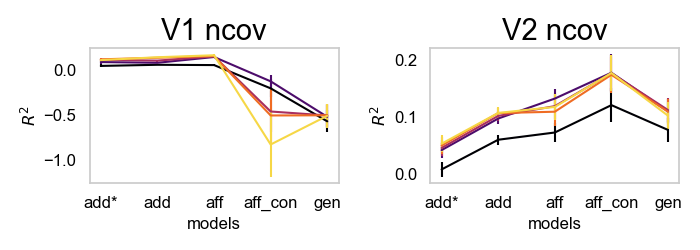

In [30]:
fig, ax = plt.subplots(1,2,figsize=(7,2.5))

for i in range(n_compo_len):
    ax[0].errorbar(range(5), np.mean(r2_nc_V1_all[:,i,:],1),np.std(r2_nc_V1_all[:,i,:],1)/np.sqrt(n_fold) , c = colors[i])
    ax[1].errorbar(range(5), np.mean(r2_nc_V2_all[:,i,:],1),np.std(r2_nc_V2_all[:,i,:],1)/np.sqrt(n_fold) , c = colors[i], label='%d ')
    

plt.sca(ax[0])
plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$')
plt.xlabel('models')
plt.title('V1 ncov')

plt.sca(ax[1])
plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$')
plt.xlabel('models')
plt.title('V2 ncov')


plt.tight_layout()


<IPython.core.display.Javascript object>


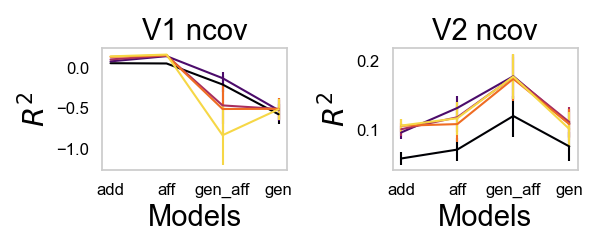

In [100]:
fig, ax = plt.subplots(1,2,figsize=(6,2.5))

for i in range(n_compo_len):
    ax[0].errorbar(range(4), np.mean(r2_nc_V1_all[1:,i,:],1),np.std(r2_nc_V1_all[1:,i,:],1)/np.sqrt(n_fold) , c = colors[i])
    ax[1].errorbar(range(4), np.mean(r2_nc_V2_all[1:,i,:],1),np.std(r2_nc_V2_all[1:,i,:],1)/np.sqrt(n_fold) , c = colors[i], label='%d ')
    

plt.sca(ax[0])
plt.xticks(range(len(model_label)-1), model_label[1:])
plt.ylabel('$R^2$', fontsize=21)
plt.xlabel('Models', fontsize=21)
plt.title('V1 ncov')

plt.sca(ax[1])
plt.xticks(range(len(model_label)-1), model_label[1:])
plt.ylabel('$R^2$', fontsize=21)
plt.xlabel('Models', fontsize=21)
plt.title('V2 ncov')


plt.tight_layout()
#plt.savefig('2023_fig/contrast_neuropixel/r^2_neuropixel_150.pdf', transparent=True)

<IPython.core.display.Javascript object>


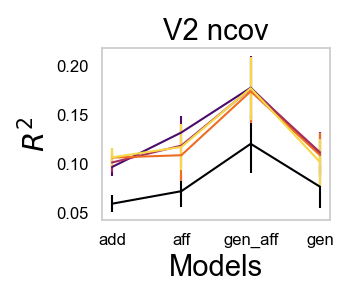

In [163]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3))

for i in range(n_compo_len):
    ax.errorbar(range(4), np.mean(r2_nc_V2_all[1:,i,:],1),np.std(r2_nc_V2_all[1:,i,:],1)/np.sqrt(n_fold) , c = colors[i], label='%d ')
    
plt.sca(ax)
plt.xticks(range(len(model_label)-1), model_label[1:])
plt.ylabel('$R^2$', fontsize=21)
plt.xlabel('Models', fontsize=21)
plt.title('V2 ncov')

plt.tight_layout()
#plt.savefig('2023_fig/contrast_neuropixel/r^2_neuropixel_150_only_V2.pdf', transparent=True)

In [164]:
def calculate_pair_mean_ncov(ncov_V1, n1, n_stim=24):
    x1 = np.zeros((int(n1*(n1-1)/2), n_stim))

    for stim_i in range(n_stim):
        tmp1 = ncov_V1[:,:, stim_i]
        x1[:, stim_i] = tmp1[np.triu_indices(n1, 1)]
        
    x1_stim = np.mean(x1,0).reshape((8, 3), order='F')
    
    return x1_stim

ncov_mean_V1_all = np.zeros((8,3, n_fold))
ncov_mean_V2_all = np.zeros((8,3, n_fold))

ncov_mean_model_V1_all = np.zeros((8,3, 5, n_fold)) #5 different model
ncov_mean_model_V2_all = np.zeros((8,3, 5, n_fold))


comp_ind =1
for j in range(n_fold):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    for i in [comp_ind]:
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        aff_model_contrast_V1 = aff_model_contrast_V1_all[i+j*n_compo_len]
        
        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        aff_model_contrast_V2 = aff_model_contrast_V2_all[i+j*n_compo_len]
        
        ncov_V1= calculate_nc(x_test1, n1, n_trial_test, n_stim)
        ncov_V2= calculate_nc(x_test2, n2, n_trial_test, n_stim)

        phi_V1 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, aff_model_V1, aff_model_contrast_V1, gen_model_V1, n_stim=24)
        phi_V2 = calculate_phi_from_model(add_model_V2, add_varp_model_V2, aff_model_V2, aff_model_contrast_V2, gen_model_V2, n_stim=24)
        
        ncov_from_phi_V1 = [np.zeros((n1,n1,n_stim))]*5
        ncov_from_phi_V2 = [np.zeros((n2,n2,n_stim))]*5
        
        for model_i, phi in enumerate(phi_V1):
            ncov_from_phi_V1[model_i] = calculate_ncov_from_phi(phi)
            ncov_mean_model_V1_all[:,:,model_i,j] = calculate_pair_mean_ncov(ncov_from_phi_V1[model_i], n1)
            
        for model_i, phi in enumerate(phi_V2):
            ncov_from_phi_V2[model_i] = calculate_ncov_from_phi(phi)
            ncov_mean_model_V2_all[:,:,model_i,j] = calculate_pair_mean_ncov(ncov_from_phi_V2[model_i], n2)
            
            
        ncov_mean_V1_all[:,:,j] = calculate_pair_mean_ncov(ncov_V1, n1)
        ncov_mean_V2_all[:,:,j] = calculate_pair_mean_ncov(ncov_V2, n2)
        
        




<IPython.core.display.Javascript object>


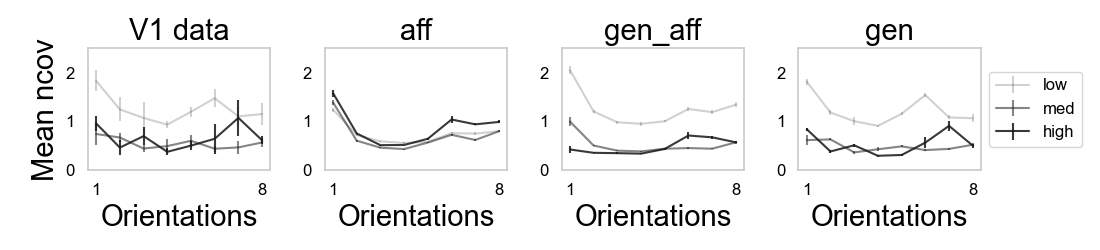

In [165]:
contrast_label = ['low','med', 'high']

fig, ax = plt.subplots(1,4, figsize=(11,2.5))
plt.sca(ax[0])
#plt.plot(np.mean(ncov_mean_V1_all,2))
for contrast_ind in range(3):
    tmp = ncov_mean_V1_all[:,contrast_ind,:]
    plt.errorbar(range(8), np.mean(tmp,1), np.std(tmp,1)/np.sqrt(n_fold), alpha=(0.2+contrast_ind/3), c='k')

    
ymin = 0
ymax = 2.5

plt.ylim([ymin, ymax])
plt.ylabel('Mean ncov', fontsize=21)
plt.title('V1 data', fontsize=21)
plt.xlabel('Orientations', fontsize=21)
plt.xticks([0,7],[1,8])

for model_ind in [2,3,4]:
    plt.sca(ax[model_ind-1])
    for contrast_ind in range(3):
        tmp = ncov_mean_model_V1_all[:,contrast_ind,model_ind,:]
        plt.errorbar(range(8), np.mean(tmp,1), np.std(tmp,1)/np.sqrt(n_fold), alpha=(0.2+contrast_ind/3),  c='k', label=contrast_label[contrast_ind])
    plt.ylim([ymin, ymax])
    plt.xlabel('Orientations', fontsize=21)
    plt.title(model_label[model_ind])
    plt.xticks([0,7],[1,8])

# Shrink current axis by 20%
box = ax[-1].get_position()
ax[-1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.savefig('2023_fig/contrast_neuropixel/mean_ncov_V1_comp2.pdf', transparent=True)

<IPython.core.display.Javascript object>


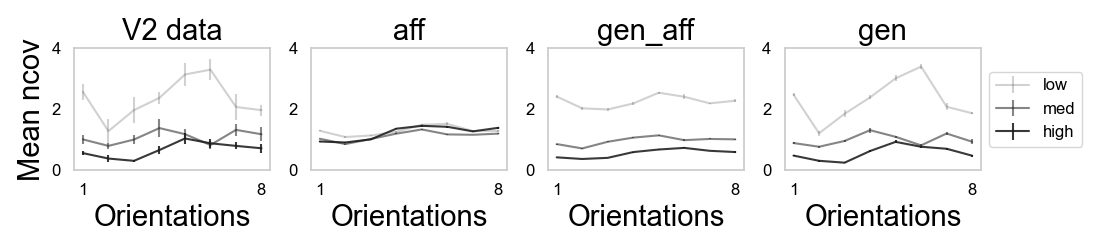

In [166]:
contrast_label = ['low','med', 'high']

fig, ax = plt.subplots(1,4, figsize=(11,2.5))
plt.sca(ax[0])

for contrast_ind in range(3):
    tmp = ncov_mean_V2_all[:,contrast_ind,:]
    plt.errorbar(range(8), np.mean(tmp,1), np.std(tmp,1)/np.sqrt(n_fold), alpha=(0.2+contrast_ind/3), c='k')

    
ymin = 0
ymax = 4

plt.ylim([ymin, ymax])
plt.ylabel('Mean ncov', fontsize=21)
plt.title('V2 data', fontsize=21)
plt.xlabel('Orientations', fontsize=21)
plt.xticks([0,7],[1,8])

for model_ind in [2,3,4]:
    plt.sca(ax[model_ind-1])
    for contrast_ind in range(3):
        tmp = ncov_mean_model_V2_all[:,contrast_ind,model_ind,:]
        plt.errorbar(range(8), np.mean(tmp,1), np.std(tmp,1)/np.sqrt(n_fold), alpha=(0.2+contrast_ind/3),  c='k', label=contrast_label[contrast_ind])
    plt.ylim([ymin, ymax])
    plt.xlabel('Orientations', fontsize=21)
    plt.title(model_label[model_ind])
    plt.xticks([0,7],[1,8])

# Shrink current axis by 20%
box = ax[-1].get_position()
ax[-1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.savefig('2023_fig/contrast_neuropixel/mean_ncov_V2_comp2.pdf', transparent=True)

<IPython.core.display.Javascript object>


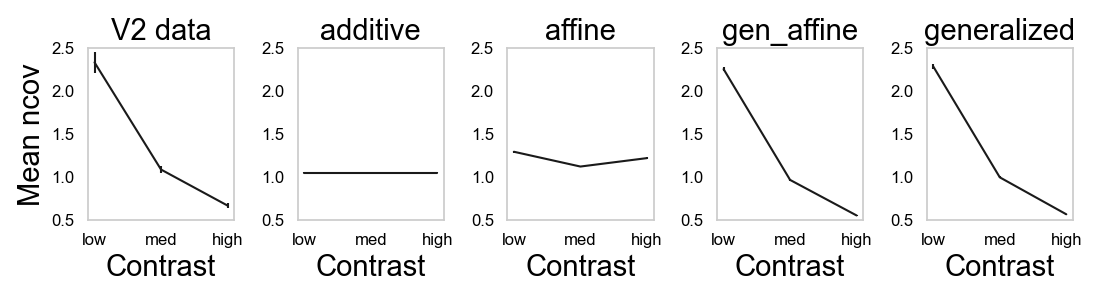

In [203]:
contrast_label = ['low','med', 'high']
model_label = ['add*', 'additive', 'affine', 'gen_affine', 'generalized']

fig, ax = plt.subplots(1,5, figsize=(11,3))
plt.sca(ax[0])
tmp = np.mean(ncov_mean_V2_all,0)
plt.errorbar(range(3), np.mean(tmp,1), np.std(tmp,1)/np.sqrt(n_fold), c='k')

ymin = 0.5
ymax = 2.5

plt.ylim([ymin, ymax])
plt.ylabel('Mean ncov', fontsize=21)
plt.title('V2 data', fontsize=21)
plt.xlabel('Contrast', fontsize=21)
plt.xticks([0,1,2],['low','med','high'])

for model_ind in [1,2,3,4]:
    plt.sca(ax[model_ind])
    #plt.sca(ax[0])
    tmp = np.mean(ncov_mean_model_V2_all[:,:,model_ind,:],0)
    plt.errorbar(range(3), np.mean(tmp,1), np.std(tmp,1)/np.sqrt(n_fold), c='k')
    
    plt.ylim([ymin, ymax])
    plt.xlabel('Contrast',fontsize=21)
    plt.title(model_label[model_ind])
    plt.xticks([0,1,2],['low','med','high'])

plt.tight_layout()
#plt.savefig('2023_fig/contrast_neuropixel/mean_ncov_V2_comp2_simplified.pdf', transparent=True)

## Visualize the amplitude of shared variability $\phi$ from the fitted statistical models

In [24]:
for j in range(1):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    for i in range(1):
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        aff_model_contrast_V1 = aff_model_contrast_V1_all[i+j*n_compo_len]
        
        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        aff_model_contrast_V2 = aff_model_contrast_V2_all[i+j*n_compo_len]
        
        ncov_V1= calculate_nc(x_test1, n1, n_trial_test, n_stim)
        ncov_V2= calculate_nc(x_test2, n2, n_trial_test, n_stim)

        phi_V1 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, aff_model_V1, aff_model_contrast_V1, gen_model_V1, n_stim=24)
        phi_V2 = calculate_phi_from_model(add_model_V2, add_varp_model_V2, aff_model_V2, aff_model_contrast_V2, gen_model_V2, n_stim=24)
        
        ncov_from_phi_V1 = [np.zeros((n1,n1,n_stim))]*5
        ncov_from_phi_V2 = [np.zeros((n2,n2,n_stim))]*5
        
        for model_i, phi in enumerate(phi_V1):
            ncov_from_phi_V1[model_i] = calculate_ncov_from_phi(phi)
            
        for model_i, phi in enumerate(phi_V2):
            ncov_from_phi_V2[model_i] = calculate_ncov_from_phi(phi)

In [25]:
def plot_shared_noise_coef(phi_V1, d, tuning_order, title):
    n = len(tuning_order)
    plt.figure(figsize=(11,3))
    ax1 = plt.subplot(151)
    plt.imshow(d[tuning_order,:], aspect='auto', cmap='viridis')#, vmin=0, vmax=np.max(gen_model.d_p))
    plt.title('Trial-avg')
    plt.ylabel('Neuron',fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.yticks([0, n-1],[1,n])
    plt.xticks(np.arange(7., 24,8),[8,16,24])
    ax1.tick_params(bottom=True)
    cbar = plt.colorbar()
    
    bbox = cbar.ax.get_position()
    plt.text(bbox.x0 + bbox.width / 2, 1.02, '(Hz)', transform=cbar.ax.transAxes, va='bottom', ha='left')



    F_p = phi_V1[-1][:,0,:]
    for stim_i in range(n_stim):
    # unify the sign of F_p across stimuli. 
        if stim_i ==0:
            ref_F = F_p[:,0]
        else:
            sign = (np.sum(ref_F * F_p[:, stim_i]) > np.sum(-ref_F * F_p[:, stim_i]))
            if not sign:
                F_p[:, stim_i] *= -1


    sign = 1
    if np.sum(ref_F)<0:
        F_p = F_p*-1
        sign = -1

    ax5 = plt.subplot(155)
    plt.title('Generalized')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(np.arange(7, 24,8),[8,16,24])
    plt.yticks([0],[' '])
    ax5.tick_params(bottom=True)
    plt.imshow(F_p[tuning_order,:], aspect='auto', vmin=0, vmax=np.min([np.max(F_p),12]))
    plt.colorbar()

    ax3 = plt.subplot(153)
    plt.imshow(phi_V1[2][tuning_order,0,:], aspect='auto', vmin=0, vmax=np.min([np.max(F_p),12]))
    plt.title('Affine')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(np.arange(7, 24,8),[8,16,24])
    plt.yticks([])
    plt.colorbar()
    ax3.tick_params(bottom=True)
    
    ax4 = plt.subplot(154)
    plt.imshow(phi_V1[3][tuning_order,0,:], aspect='auto', vmin=0, vmax=np.min([np.max(F_p),12]))
    plt.title('Gen_affine')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(np.arange(7, 24,8),[8,16,24])
    plt.yticks([])
    plt.colorbar()
    ax4.tick_params(bottom=True)

    ax2 = plt.subplot(152)
    plt.title('Additive')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(np.arange(7, 24,8),[8,16,24])
    plt.yticks([])
    plt.imshow(phi_V1[1][tuning_order,0,:], aspect='auto', vmin=0, vmax=np.min([np.max(F_p),12]))
    plt.colorbar()
    ax2.tick_params(bottom=True)


    #plt.suptitle(title)
    plt.tight_layout()



<IPython.core.display.Javascript object>


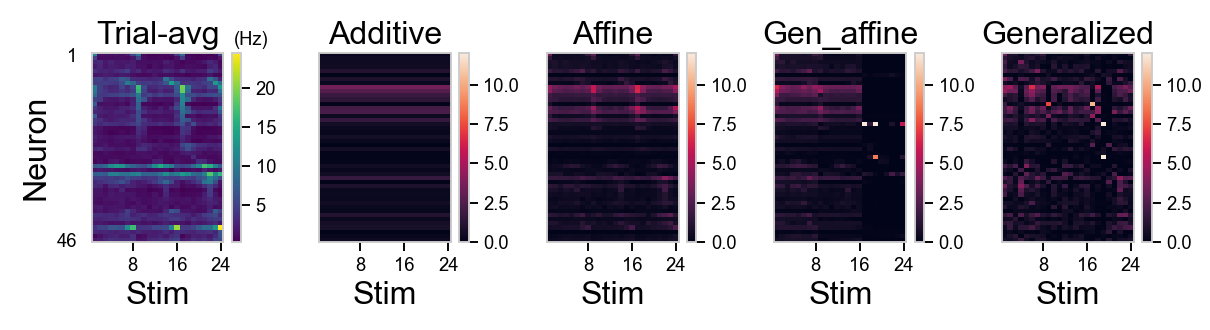

<IPython.core.display.Javascript object>


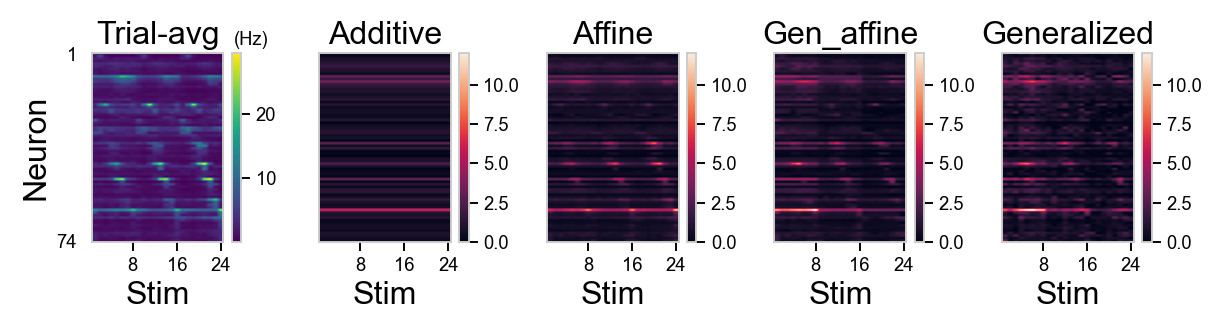

In [27]:
plot_shared_noise_coef(phi_V1, gen_model_V1.d_p, tuning_order_V1, r'V1 shared noise amplitude $\phi$')
#plt.savefig('2023_fig/contrast_neuropixel/phi_component1_V1_150.pdf', transparent=True)
plot_shared_noise_coef(phi_V2, gen_model_V2.d_p, tuning_order_V2, r'V2 shared noise amplitude $\phi$')
#plt.savefig('2023_fig/contrast_neuropixel/phi_component1_V2_150_with_updated_histology_revised.pdf', transparent=True)